In [21]:
## Import modules
import numpy as np
import pandas as pd
import os 
import time
import math
import sklearn

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import time

In [2]:
df = pd.read_csv(r'C:\dev\data\health\dataSets\wave4_gluc_dummies.csv')

In [3]:
def getOrigDsColMap():
    dataSets = []
    dataSetNms = []
    
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\glucoseHomeostasis.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("glucHome")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\inflammationAndImmuneFunction.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("infImmFunc")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\lipids.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("lipids")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave1_inHomeQuest.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave1")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave2_inHomeQuest.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave2")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave3_inHomeQuest.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave3")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave4_inHomeQuest.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave4")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave1_publicUseContDB.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave1_publicUse")
    dataSets.append(pd.read_csv(r'C:\dev\data\health\dataSets\wave2_publicUseContDB.tsv', sep='\t', header=0, na_values=' ').columns)
    dataSetNms.append("wave2_publicUse")
    
    colMap = dict()
    
    for i in range(len(dataSets)):
        dsNm = dataSetNms[i]
        
        for colNm in dataSets[i]:
            if colNm not in colMap:
                colMap[colNm] = []
            colMap[colNm].append(dsNm)
    
    return colMap

In [4]:
colMap = getOrigDsColMap()

In [5]:
for col in df.columns:
    if "H4" not in col:
        print(col)

Unnamed: 0
IDAY4
C4WD60_3
C4WD60_2
C4WD60_1
C4WD90_2
C4WD90_1
C_JOINT
AID
C4WD90_3
C_MED_0
C_MED_1
PRETEST4_0
PRETEST4_1
BIO_SEX4_1
BIO_SEX4_2
PRISON4_0
C4NUMSCR_0
C4NUMSCR_1
C4NUMSCR_2
C4NUMSCR_3
C4NUMSCR_4
C4NUMSCR_5
C4NUMSCR_6
C4NUMSCR_7


In [11]:
yNm = "C_JOINT"
notIVs = ["AID", "C_MED_0", "C_MED_1", "H4ID5D_0", "H4ID5D_1", "H4ID5D_6", "Unnamed: 0"] #
notIVs.append(yNm)
XNms = df.columns.drop(notIVs)

y = df[yNm]
X_all = df[XNms]

In [12]:
corrs = []

for col in XNms:
    corrV = y.corr(df[col], method='pearson')
    corrs.append((col, corrV))
    
corrs = sorted(corrs, key=lambda x: abs(x[1]), reverse=True)

corrs[:20]

[('H4BMICLS_6', 0.14762744482696935),
 ('H4GH7_5', 0.12683015365897526),
 ('H4ID5C_1', 0.12608018339924179),
 ('H4ID5C_0', -0.12551556984580567),
 ('H4ID5B_1', 0.1039887693461899),
 ('H4ID5B_0', -0.10366950707175322),
 ('H4CUFF_1.0', -0.097946464943772224),
 ('H4GH1_5', 0.097059839388281291),
 ('H4BPCLS_4.0', 0.08612792874714803),
 ('H4PE4_1.0', 0.083162222434263175),
 ('H4CUFF_2.0', 0.080699661210365162),
 ('H4GH6', 0.074738455723797587),
 ('H4GH7_3', -0.074601006892597271),
 ('H4DA18_1.0', 0.074079199277823277),
 ('H4DS3_1', 0.07392486109530795),
 ('H4WP26_0', -0.072921165531824039),
 ('H4TO40', 0.071931714001894992),
 ('H4HS5_1', 0.06984083969504809),
 ('H4WP13', 0.069586805157443019),
 ('H4ID10F_1', 0.069009244166568617)]

In [13]:
X_sub = X_all[[col[0] for col in corrs[:500]]]
X = X_sub

In [37]:
mod = DecisionTreeClassifier(min_samples_split=62, max_depth=8, class_weight={0: 1, 1: 8})

kf = KFold(n_splits=5)

trainScores =[]
testScores =[]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    mod.fit(X_train, y_train)

    trainScore = recall_score(y_train, mod.predict(X_train))
    testScore = recall_score(y_test, mod.predict(X_test))
    
    trainScores.append(trainScore)
    testScores.append(testScore)
    
    print("Train %5.3f" % trainScore)
    print("Test  %5.3f" % testScore)
    
    
print("\nAverages")
print("Train %5.3f" % np.mean(trainScores))
print("Test  %5.3f" % np.mean(testScores))

Train 0.894
Test  0.459
Train 0.874
Test  0.329
Train 0.784
Test  0.373
Train 0.745
Test  0.294
Train 0.801
Test  0.316

Averages
Train 0.819
Test  0.354


0.840658238009
             precision    recall  f1-score   support

          0       0.98      0.84      0.91      4625
          1       0.28      0.79      0.42       358

avg / total       0.93      0.84      0.87      4983



[<matplotlib.text.Text at 0x135aef98>, <matplotlib.text.Text at 0x11d68ac8>]

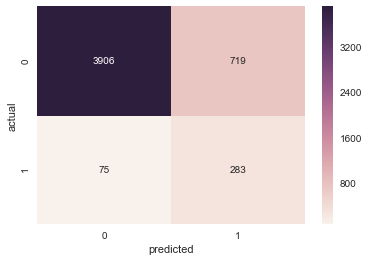

In [38]:
mod = DecisionTreeClassifier(min_samples_split=62, max_depth=8, class_weight={0: 1, 1: 8})

mod.fit(X, y)

print(mod.score(X, y))

preds = mod.predict(X)
print classification_report(y, preds)

cMat = confusion_matrix(y, preds)
ax = sn.heatmap(cMat, annot=True, fmt="d")
ax.set(xlabel='predicted', ylabel='actual')

In [27]:
def gridSearchPrecRec(X, y, model, pGrid, jobs=3):
    
    start = time.time()
    gs = GridSearchCV(model, cv=5, n_jobs=jobs, scoring='precision',
                   param_grid=pGrid
                 )
    gs.fit(X, y)

    precisionScores = gs.cv_results_['mean_test_score']
    params = gs.cv_results_['params']

    print("Precision took %f minutes" % ((time.time() - start)/60.0))
    
    
    start2 = time.time()
    gs = GridSearchCV(model, cv=5, n_jobs=jobs, scoring='recall',
                       param_grid=pGrid
                     )
    gs.fit(X, y)

    recallScores = gs.cv_results_['mean_test_score']
    
    print("Recall took %f minutes" % ((time.time() - start2)/60.0))
    print("Overall took %f minutes" % ((time.time() - start)/60.0))
    
    return zip(recallScores, precisionScores, params)

In [28]:
def getBestScores(scores):
    sScores = sorted(scores, key=lambda x:x[0], reverse=True)

    bestScores = []
    otherScores = []

    bestPrecision = 0
    for x in sScores:
        if x[1] > bestPrecision:
            bestPrecision = x[1]
            bestScores.append(x)
        else:
            otherScores.append(x)
            
    return (bestScores, otherScores)

In [53]:
def labelPlotScores(labelScores, unlabeledScores=None):
    
    xVals = [x[0] for x in labelScores]
    yVals = [x[1] for x in labelScores]
    plt.plot(xVals, yVals,'go')
    
    if unlabeledScores is not None:
        plt.plot([x[0] for x in unlabeledScores], [x[1] for x in unlabeledScores],'bo')
        
    plt.xlabel('recall')
    plt.ylabel('precision')
    axes = plt.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])

    angle = 2 * np.pi * np.random.uniform()
    dist = .04

    for i in range(len(xVals)):
        angle += np.pi/2
        xOff = np.cos(angle) * dist
        yOff = np.sin(angle) * dist

        plt.annotate(
                str(i),
                xy=(xVals[i], yVals[i]), 
            xytext=(xVals[i]+xOff, yVals[i]+yOff))

    plt.show()

Precision took 0.968133 minutes
Recall took 0.979217 minutes
Overall took 1.947383 minutes


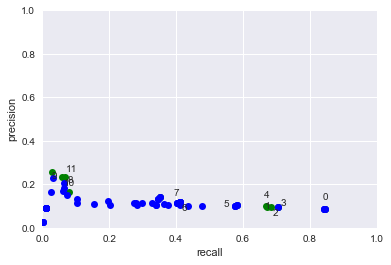

In [41]:
pGrid = {"min_samples_split": [8, 32, 64]
        ,"class_weight":[{0:1,1:1},{0:1,1:8},{0:1,1:32}]
        ,"max_depth":[4, 8, 16, 32]
        ,"min_samples_leaf":[2, 32],
         "random_state":[43]
        }

dTreeScores = gridSearchPrecRec(X, y, DecisionTreeClassifier(), pGrid)

dTreeBestScores, dTreeOtherScores = getBestScores(dTreeScores)

labelPlotScores(dTreeBestScores, dTreeOtherScores)

In [21]:
dTreeBestScores[10]

(0.30184239914237149,
 0.097577913161702293,
 {'class_weight': {0: 1, 1: 8},
  'max_depth': 8,
  'min_samples_leaf': 2,
  'min_samples_split': 64})

Precision took 10.964600 minutes
Recall took 10.830983 minutes
Overall took 21.795600 minutes


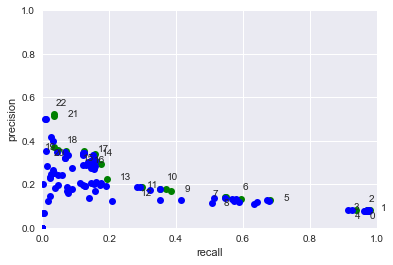

In [32]:
pGrid = {"min_samples_split": [8, 32, 64]
        ,"class_weight":[{0:1,1:1},{0:1,1:8},{0:1,1:32}]
        ,"max_depth":[4, 8, 16, 32]
        ,"n_estimators":[8,32,64,128,256]
        ,"random_state":[43]
        }

rfScores = gridSearchPrecRec(X, y, RandomForestClassifier(), pGrid)

rfBestScores, rfOtherScores = getBestScores(rfScores)

labelPlotScores(rfBestScores, rfOtherScores)

In [40]:
print(rfBestScores[7])

(0.54764061659407237, 0.14054254085288345, {'min_samples_split': 8, 'n_estimators': 256, 'random_state': 43, 'max_depth': 8, 'class_weight': {0: 1, 1: 32}})


In [34]:
for r in rfBestScores:
    print("[%6.4f, %6.4f]," % (r[0], r[1]))

[0.9805, 0.0797],
[0.9721, 0.0798],
[0.9721, 0.0804],
[0.9694, 0.0808],
[0.9358, 0.0825],
[0.6816, 0.1270],
[0.5951, 0.1340],
[0.5476, 0.1405],
[0.5449, 0.1425],
[0.3856, 0.1671],
[0.3690, 0.1797],
[0.3521, 0.1800],
[0.2990, 0.1878],
[0.1929, 0.2252],
[0.1761, 0.2938],
[0.1620, 0.3066],
[0.1564, 0.3383],
[0.1256, 0.3510],
[0.0699, 0.3539],
[0.0475, 0.3567],
[0.0364, 0.3734],
[0.0363, 0.5142],
[0.0363, 0.5233],


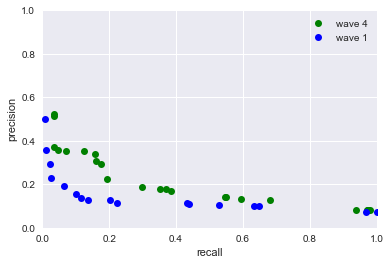

In [35]:
v1 = [[1.0000, 0.0713],
[0.9668, 0.0732],
[0.6481, 0.0983],
[0.6315, 0.1008],
[0.5290, 0.1068],
[0.4376, 0.1096],
[0.4320, 0.1123],
[0.2244, 0.1162],
[0.2022, 0.1279],
[0.1357, 0.1282],
[0.1161, 0.1351],
[0.0997, 0.1573],
[0.0664, 0.1916],
[0.0249, 0.2268],
[0.0221, 0.2933],
[0.0110, 0.3571],
[0.0083, 0.4998]]

v4 = [[x[0], x[1]] for x in rfBestScores]

    
xVals = [x[0] for x in v4]
yVals = [x[1] for x in v4]
plt.plot(xVals, yVals,'go')

plt.plot([x[0] for x in v1], [x[1] for x in v1],'bo', label='Line 2')

plt.xlabel('recall')
plt.ylabel('precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])

# line_up, = plt.plot([1,2,3], label='Line 2')
# line_down, = plt.plot([3,2,1], label='Line 1')
plt.legend(labels=["wave 4", "wave 1"])

plt.show()

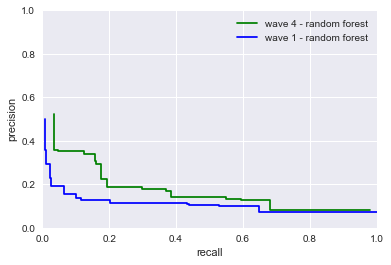

In [50]:
xVals = [x[0] for x in v4]
yVals = [x[1] for x in v4]
plt.step(xVals, yVals,'g', where='post')

plt.step([x[0] for x in v1], [x[1] for x in v1],'b', where='post')

plt.xlabel('recall')
plt.ylabel('precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])

# line_up, = plt.plot([1,2,3], label='Line 2')
# line_down, = plt.plot([3,2,1], label='Line 1')
plt.legend(labels=["wave 4 - random forest", "wave 1 - random forest"])

plt.show()

             precision    recall  f1-score   support

          0       1.00      0.73      0.84      4625
          1       0.22      1.00      0.36       358

avg / total       0.94      0.75      0.81      4983



[<matplotlib.text.Text at 0x132ffdd8>, <matplotlib.text.Text at 0x17f0d320>]

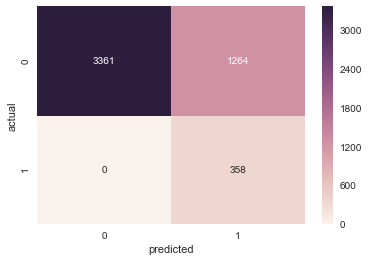

In [48]:
#rfBestScores[7]

mod = RandomForestClassifier(min_samples_split=8, class_weight={0:1,1:32}, max_depth=8, n_estimators=256, random_state=43)

mod.fit(X, y)

preds = mod.predict(X)
print classification_report(y, preds)

cMat = confusion_matrix(y, preds)
ax = sn.heatmap(cMat, annot=True, fmt="d")
ax.set(xlabel='predicted', ylabel='actual')

             precision    recall  f1-score   support

          0       1.00      0.96      0.98      4625
          1       0.64      0.95      0.76       358

avg / total       0.97      0.96      0.96      4983



[<matplotlib.text.Text at 0x1513fb38>, <matplotlib.text.Text at 0x181472e8>]

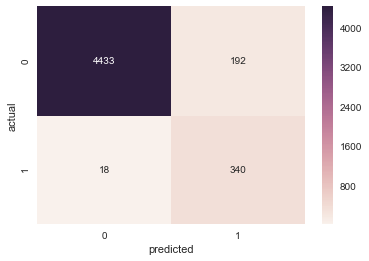

In [87]:
#rfBestScores[7]

mod = RandomForestClassifier(min_samples_split=64, class_weight={0:1,1:16}, max_depth=16, n_estimators=256, random_state=43)

mod.fit(X, y)

preds = mod.predict(X)
print classification_report(y, preds)

cMat = confusion_matrix(y, preds)
ax = sn.heatmap(cMat, annot=True, fmt="d")
ax.set(xlabel='predicted', ylabel='actual')

             precision    recall  f1-score   support

          0       1.00      0.96      0.98      4625
          1       0.64      0.94      0.76       358

avg / total       0.97      0.96      0.96      4983



[<matplotlib.text.Text at 0x18f27128>, <matplotlib.text.Text at 0x1512b908>]

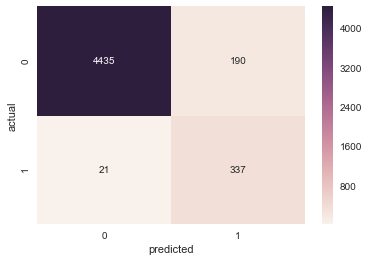

In [96]:
#rfBestScores[7]

mod = RandomForestClassifier(min_samples_split=64, class_weight={0:1,1:16}, max_depth=32, n_estimators=128, random_state=43)

mod.fit(X, y)

preds = mod.predict(X)
print classification_report(y, preds)

cMat = confusion_matrix(y, preds)
ax = sn.heatmap(cMat, annot=True, fmt="d")
ax.set(xlabel='predicted', ylabel='actual')

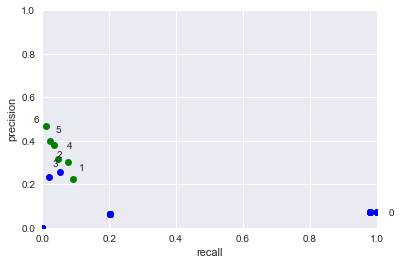

In [45]:
from sklearn.ensemble import AdaBoostClassifier

pGrid = {"n_estimators":[8,16,32,64,128],
         "learning_rate":[.01, .1, .5, 1, 2, 4, 16],
         "random_state":[43]
        }

abScores = gridSearchPrecRec(X, y, AdaBoostClassifier(), pGrid)

abBestScores, abOtherScores = getBestScores(abScores)

labelPlotScores(abBestScores, abOtherScores)

             precision    recall  f1-score   support

          0       0.87      0.23      0.37      4746
          1       0.05      0.55      0.10       361

avg / total       0.81      0.25      0.35      5107



[<matplotlib.text.Text at 0x104f4128>, <matplotlib.text.Text at 0x1448c898>]

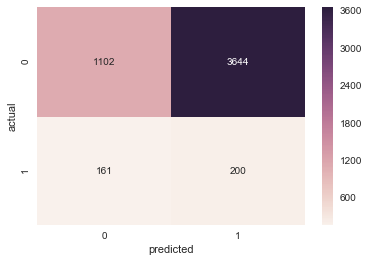

In [40]:
mod = AdaBoostClassifier(learning_rate= 2, n_estimators=8, random_state=43)

mod.fit(X, y)

preds = mod.predict(X)
print classification_report(y, preds)

cMat = confusion_matrix(y, preds)
ax = sn.heatmap(cMat, annot=True, fmt="d")
ax.set(xlabel='predicted', ylabel='actual')

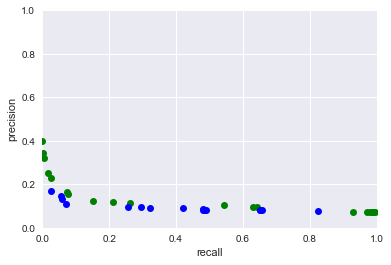

In [225]:
plt.plot([x[0] for x in rfBestScores], [x[1] for x in rfBestScores],'go')
plt.plot([x[0] for x in dTreeBestScores], [x[1] for x in dTreeBestScores],'bo')
plt.xlabel('recall')
plt.ylabel('precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])

plt.show()

In [42]:
rfBestScores[0]

NameError: name 'rfBestScores' is not defined

In [97]:
featNms = zip(XNms, mod.feature_importances_)

featNms = sorted(featNms, key=lambda(x): x[1], reverse=True)

for grp in featNms[:20]:
    colKey = grp[0]
    if "_" in colKey:
        colKey = colKey[:colKey.rfind('_')]
    
    print("%10s : %6.4f  %s" % (grp[0], grp[1], colMap[colKey][0]))

    H4MI13 : 0.0439  wave4
    H4HR8F : 0.0355  wave4
   H4MI1_0 : 0.0301  wave4
     H4CJ5 : 0.0293  wave4
    H4SE25 : 0.0270  wave4
    H4HR8H : 0.0244  wave4
    H4LM13 : 0.0186  wave4
    H4HR8I : 0.0172  wave4
    H4LM19 : 0.0130  wave4
     H4GH9 : 0.0129  wave4
  H4WP38_3 : 0.0129  wave4
 H4DA8_2.0 : 0.0127  wave4
    H4LM14 : 0.0126  wave4
    H4GH3M : 0.0113  wave4
     H4SBP : 0.0111  wave4
    H4GH3Y : 0.0105  wave4
   H4CJ25M : 0.0100  wave4
     H4WP4 : 0.0097  wave4
   H4MI11M : 0.0094  wave4
  H4RE11_4 : 0.0093  wave4


In [98]:
mod

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 16},
            criterion='gini', max_depth=32, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=64,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=False, random_state=43, verbose=0, warm_start=False)

In [91]:
featNms[14]

('Unnamed: 0', 0.0105843986342785)

In [93]:
df[]

0          0
1          1
2          2
3          3
4          4
5          5
6          6
7          8
8          9
9         10
10        11
11        12
12        13
13        14
14        15
15        16
16        17
17        18
18        19
19        20
20        21
21        22
22        23
23        24
24        25
25        26
26        27
27        28
28        29
29        30
        ... 
4953    5083
4954    5084
4955    5085
4956    5086
4957    5087
4958    5088
4959    5089
4960    5090
4961    5092
4962    5093
4963    5094
4964    5095
4965    5096
4966    5097
4967    5098
4968    5099
4969    5100
4970    5101
4971    5102
4972    5103
4973    5104
4974    5105
4975    5106
4976    5107
4977    5108
4978    5109
4979    5110
4980    5111
4981    5112
4982    5113
Name: Unnamed: 0, dtype: int64